In [2]:
from __future__ import division
%matplotlib notebook
import numpy as np
import kwant
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize_scalar
import scipy.linalg as la
import scipy
import sys
import scipy.sparse.linalg as sla
import functools as ft
import itertools as it
import tinyarray as ta
from model_lcao import L_matrices, lcao_term
from model_SnTe_models import sigmas, SnTe_6band, SnTe_18band
from model_SnTe_models import SnTe_6band_params, SnTe_18band_params, PbTe_18band_params

np.set_printoptions(precision=2, suppress=True, linewidth=150, threshold=2000)

C:\Users\pimke\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [67]:
for key in SnTe_18band_params.keys():
    print(key, ' & ', SnTe_18band_params[key], ' & ', PbTe_18band_params[key], '\\\\')

esc  &  -6.578  &  -7.612 \\
esa  &  -12.067  &  -11.002 \\
epc  &  1.659  &  3.195 \\
epa  &  -0.167  &  -0.237 \\
edc  &  8.38  &  7.73 \\
eda  &  7.73  &  7.73 \\
lambdac  &  0.592  &  1.5 \\
lambdaa  &  0.564  &  0.428 \\
vss  &  -0.51  &  -0.474 \\
vsp  &  -0.949  &  -0.705 \\
vps  &  0.198  &  -0.633 \\
vpp  &  2.218  &  2.066 \\
vpppi  &  -0.446  &  -0.43 \\
vpd  &  -1.11  &  -1.29 \\
vpdpi  &  0.624  &  0.835 \\
vdp  &  -1.67  &  -1.59 \\
vdppi  &  0.766  &  0.531 \\
vdd  &  -1.72  &  -1.35 \\
vdddelta  &  0.618  &  0.668 \\
vddpi  &  0  &  0 \\


In [77]:
syst = SnTe_18band()
print(syst)
#L_matrices()

NameError: name 'L_matrices' is not defined

In [45]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
pars['k_y'] = 0
k_s = np.linspace(-np.pi, np.pi, 100)
specs = []
for k_z in k_s:
    pars['k_z'] = k_z
    spec = la.eigh(sysw.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs.append(spec)

NameError: name 'sysw' is not defined

<IPython.core.display.Javascript object>


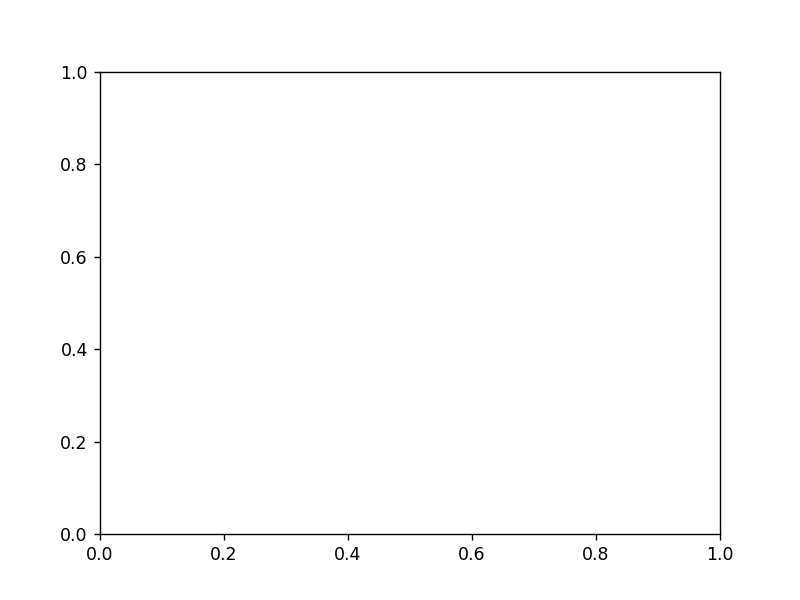

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

In [25]:
plt.plot(k_s, specs);
plt.ylim([-3, 5])

# Effective Hamiltonian

In [30]:
np.set_printoptions(precision=4, suppress=True, linewidth=150, threshold=2000)

def ndlinspace(start, end, N):
    # divide line between two points in n-dimensional space
    # evenly in N parts
    start, end = np.array(start), np.array(end)
    return np.array([start + (end - start) * x
                     for x in np.linspace(0, 1, N)])

bulk = kwant.wraparound.wraparound(syst).finalized()
# projector onto p-orbitals
P = np.hstack([np.vstack([np.zeros((2, 6)), np.eye(6), np.zeros((28, 6))]),
               np.vstack([np.zeros((20, 6)), np.eye(6), np.zeros((10, 6))])])
# k = (2.85, 0, 0)
E0 = 0.12
# print(la.eigvalsh(bulk.hamiltonian_submatrix(args=k)))
def projH(k, pars):
    params = {**pars, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]}
    return la.inv((P.T @ la.inv(bulk.hamiltonian_submatrix(params=params) - E0 * np.eye(36)) @ P)) + E0 * np.eye(12)

NameError: name 'syst' is not defined

In [32]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
XTe_18band_params = PbTe_18band_params
aks = la.norm(ks, axis=1)
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
pevs = [la.eigvalsh(projH(k, XTe_18band_params)) for k in ks]
%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band)
for band in np.array(evs).T:
    plt.plot(aks, band, '--')

NameError: name 'bulk' is not defined

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


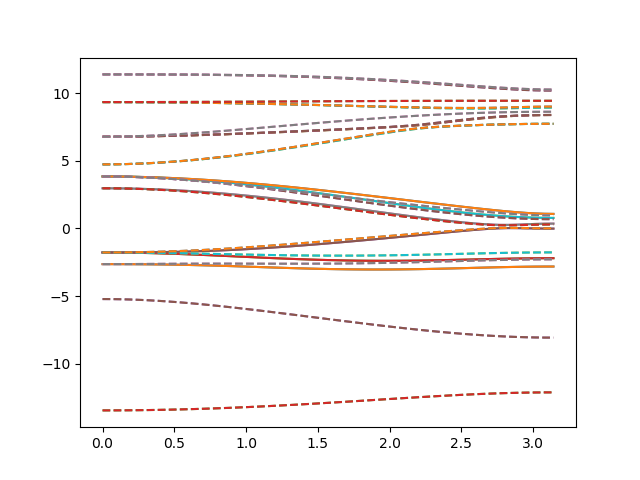

In [45]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
XTe_18band_params = SnTe_18band_params
aks = la.norm(ks, axis=1)
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
pevs = [la.eigvalsh(projH(k, XTe_18band_params)) for k in ks]
%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band)
for band in np.array(evs).T:
    plt.plot(aks, band, '--')

# Fit effective 6-band Hamiltonian with short-ranged 6-band hopping Hamiltonian

## Old method, up to nn terms with all terms allowed

In [46]:
N = 10
dk = 2 * np.pi/N
grid = np.mgrid[-np.pi:np.pi:dk, -np.pi:np.pi:dk, -np.pi:np.pi:dk].reshape(3, -1).T
print(len(grid))
%time projHs = [projH(k, XTe_18band_params) for k in grid]

1000
CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.72 s


In [47]:
lat = kwant.lattice.general(np.eye(3))
translations = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, 0, 1], [0, 1, 1])
# independent terms in the hamiltonian up to lattice translations
onsites = (lat(0, 0, 0), lat(0, 0, 1))
nnhop = np.array(((1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)))
sites = np.array(((0, 0, 0), (0, 0, 1)))
nnnhop = np.array(((1, 1, 0), (1, -1, 0), (1, 0, 1), (1, 0, -1), (0, 1, 1), (0, 1, -1)))
nnnnhop = np.array(it.product([-1, 1], repeat=3))

# calculate nn hoppings
Hnn = []
for d in nnhop:
    orbsi = slice(0, 6)
    orbsj = slice(6, 12)
    # define dummy system to get the phase convention
    dummy = kwant.Builder(symmetry=translations)
    for l in onsites:
        dummy[l] = 0
    dummy[(lat(0, 0, 0), lat(*d))] = 1
    dummy = kwant.wraparound.wraparound(dummy).finalized()
    dummys = [dummy.hamiltonian_submatrix(
                    params={'k_x': k[0], 'k_y': k[1], 'k_z': k[2]}
                                            )[0, 1] for k in grid]
    term = np.sum([dum.conj() * projHs[i][orbsi, orbsj] for i, dum in enumerate(dummys)], axis=0) / len(grid)
    Hnn.append(term)

# calculate onsites
Hos = []
for i in range(len(onsites)):
    orbs = slice(6*i, 6*(i+1))
    term = np.sum([projHs[i][orbs, orbs] for i in range(len(grid))], axis=0) / len(grid)
    Hos.append(term)

# calculate nnn hoppings
Hnnn = []
for s, d in it.product(sites, nnnhop):
    i = np.sum(s) % 2
    orbs = slice(6*i, 6*(i+1))
    # define dummy system to get the phase convention
    dummy = kwant.Builder(symmetry=translations)
    for l in onsites:
        dummy[l] = np.zeros((2, 2))
    dummy[(lat(*s), lat(*(s + d)))] = np.array([[0, 1], [0, 0]])
    dummy = kwant.wraparound.wraparound(dummy).finalized()
    dummys = [dummy.hamiltonian_submatrix(
                    params={'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})[2*i, 2*i+1] for k in grid]
    term = np.sum([dum.conj() * projHs[i][orbs, orbs] for i, dum in enumerate(dummys)], axis=0) / len(grid)
    Hnnn.append(term)

# Hnnn = []
# for d in nnnhop:
#     orbsi = slice(0, 6)
#     orbsj = slice(6, 12)
#     # define dummy system to get the phase convention
#     dummy = kwant.Builder(symmetry=translations)
#     for l in onsites:
#         dummy[l] = 0
#     dummy[(lat(0, 0, 0), lat(*d))] = 1
#     dummy = kwant.wraparound.wraparound(dummy).finalized()
#     dummys = [dummy.hamiltonian_submatrix(
#                     params={'k_x': k[0], 'k_y': k[1], 'k_z': k[2]}
#                                             )[0, 1] for k in grid]
#     term = np.sum([dum.conj() * projHs[i][orbsi, orbsj] for i, dum in enumerate(dummys)], axis=0) / len(grid)
#     Hnnn.append(term)

# print(Hos[0])
# Hnnn[0]

In [48]:
# Rebuild the Hamiltonian
# calculate onsites
effective = kwant.Builder(symmetry=translations)

for l, os in zip(onsites, Hos):
    effective[l] = os
    
for d, hop in zip(nnhop, Hnn):
    effective[(lat(0, 0, 0), lat(*d))] = hop

for (s, d), hop in zip(it.product(sites, nnnhop), Hnnn):
    effective[(lat(*s), lat(*(s + d)))] = hop

# for d, hop in zip(nnnhop, Hnnn):
#     effective[(lat(0, 0, 0), lat(*d))] = hop

effective = kwant.wraparound.wraparound(effective)
effective = effective.finalized()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


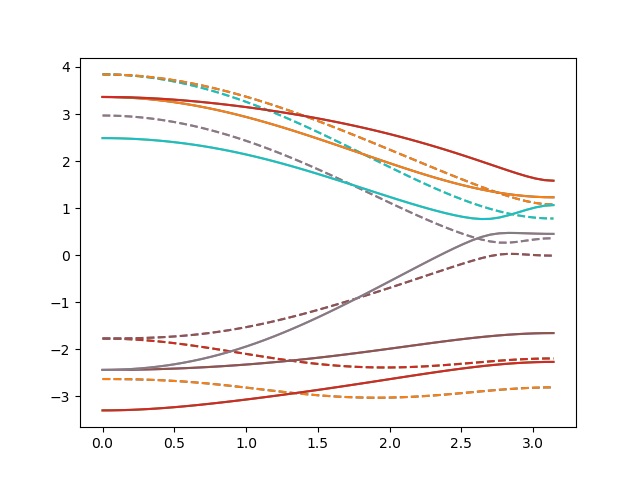

In [49]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(
                    params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
pevs = [la.eigvalsh(projH(k, XTe_18band_params)) for k in ks]
effevs = [la.eigvalsh(effective.hamiltonian_submatrix(
                    params={'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
# for band in np.array(evs).T:
#     plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

## New method, with only specific terms allowed

Calculate overlap between effective Hamiltonian and model Hamiltonians

In [50]:
# projector onto p-orbitals
P = np.hstack([np.vstack([np.zeros((2, 6)), np.eye(6), np.zeros((28, 6))]),
               np.vstack([np.zeros((20, 6)), np.eye(6), np.zeros((10, 6))])])

E0 = 0.12
# print(la.eigvalsh(bulk.hamiltonian_submatrix(args=k)))
def proj_h(params):
    return la.inv((P.T @ la.inv(bulk.hamiltonian_submatrix(params=params) - E0 * np.eye(36)) @ P)) + E0 * np.eye(12)

def overlap(ham1, ham2, grid, params1, params2):
    overlaps = []
    norm = []
    for k in grid:
        pars1 = {**params1, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]}
        pars2 = {**params2, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]}
        H1 = ham1(params=pars1)
        H2 = ham2(params=pars2)
        overlaps.append(np.trace(H1.T.conj() @ H2))
        norm.append(np.trace(H2.T.conj() @ H2))
    # print(overlaps)
    return np.sum(overlaps)/np.sum(norm)

In [65]:
# better effective Hamiltonian
def proj_h(params):
    H = bulk.hamiltonian_submatrix(params=params)
    evals, evecs = la.eigh(H)
    # pick out the interesting bands
    overlaps = evecs.T.conj() @ (P @ P.T) @ evecs
    indices = np.argsort(np.diag(overlaps))[-12:]
    evecs = evecs[:, indices]
    # print(evecs.shape)
    phi0 = (evecs @ evecs.T.conj()) @ P
    # print(phi0.shape)
    S = la.inv(la.sqrtm(phi0.T.conj() @ phi0))
    phi1 = phi0 @ S
    assert np.allclose(phi1.T.conj() @ phi1, np.eye(12))
    return phi1.T.conj() @ H @ phi1

### nnn model with only sigma hoppings

In [66]:
%%time
syst2 = kwant.wraparound.wraparound(SnTe_6band()).finalized()
t_fit = np.zeros((2, 2), dtype=complex)
m_fit = np.zeros((2,), dtype=complex)
lam_fit = np.zeros((2,), dtype=complex)

for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'t': t_bas, 'm': np.zeros((2,)), 'lam': np.zeros((2,))}
    t_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for m_bas in np.eye(2):
    params2 = {'t': np.zeros((2, 2)), 'm': m_bas, 'lam': np.zeros((2,))}
    m_fit += m_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for lam_bas in np.eye(2):
    params2 = {'t': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': lam_bas}
    lam_fit += lam_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)

params_fit = {'t': t_fit, 'm': m_fit, 'lam': lam_fit}
print(params_fit)

{'t': array([[-0.2149+0.j,  2.0803+0.j],
       [ 2.0803+0.j, -0.0183+0.j]]), 'm': array([-0.7896-0.j,  0.9907-0.j]), 'lam': array([ 0.2370-0.j,  0.2687-0.j])}
CPU times: user 40.6 s, sys: 0 ns, total: 40.6 s
Wall time: 40.5 s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


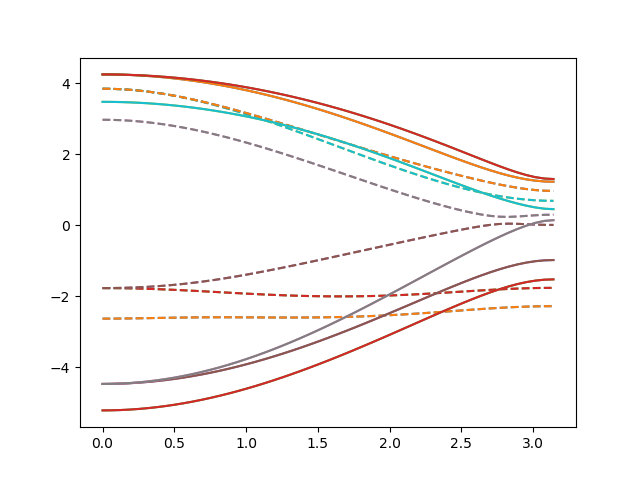

In [67]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

pevs = [la.eigvalsh(proj_h(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**params_fit, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
# for band in np.array(evs).T:
#     plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

### Extended nnn model with pi hoppings

In [68]:
def SnTe_6band_ext(translations=None):
    """Make bulk 6-band model of SnTe from https://arxiv.org/pdf/1202.1003.pdf

    translations: kwant.lattice.TranslationalSymmetry
        Optional different translational unit cell. Should still be a primitive UC.
    """

    L = L_matrices()
    ### TODO: there may be a 1/2 missing from the spin here
    L_dot_S = np.sum([np.kron(sigmas[i], L[i]) for i in range(3)], axis=0)

    def onsite(site, m, lam):
        # which sublattice
        a = np.sum(site.tag) % 2
        os = m[a] * np.eye(6)
        # L dot S onsite SoC
        spinorb = lam[a] * L_dot_S
        # x, y, z = site.pos
        os = os + spinorb
        return os

    def hopping(site1, site2, ts, tp):
        # which sublattice
        a = np.sum(site1.tag) % 2
        b = np.sum(site2.tag) % 2
        d = site1.tag - site2.tag
        # ppsigma bonding
        Hpps = np.kron(np.eye(2), lcao_term(1, 1, 0, d))
        # Use the appropriate hopping depending on sublattices
        Hppp = np.kron(np.eye(2), lcao_term(1, 1, 1, d))
        # Use the appropriate hopping depending on sublattices
        hop = tp[a, b] * Hppp + ts[a, b] * Hpps
        return hop

    # Cubic rocksalt structure with FCC symmetry
    lat = kwant.lattice.general(np.eye(3), norbs=6)
    if translations is None:
        # Default translation vectors of FCC structure
        translations = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, 0, 1], [0, 1, 1])
    syst = kwant.Builder(symmetry=translations)

    # Populate the builder using the cubic lattice sites
    # Two sublattices
    syst[lat(0, 0, 0)] = onsite
    syst[lat(0, 0, 1)] = onsite

    # First and second neighbor hoppings
    syst[lat.neighbors(1)] = hopping
    syst[lat.neighbors(2)] = hopping

    return syst


In [69]:
%%time
syst2 = kwant.wraparound.wraparound(SnTe_6band_ext()).finalized()
ts_fit = np.zeros((2, 2), dtype=complex)
tp_fit = np.zeros((2, 2), dtype=complex)
m_fit = np.zeros((2,), dtype=complex)
lam_fit = np.zeros((2,), dtype=complex)

for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': t_bas, 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,))}
    ts_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, SnTe_18band_params, params2)
for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': t_bas, 'm': np.zeros((2,)), 'lam': np.zeros((2,))}
    tp_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, SnTe_18band_params, params2)
for m_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': m_bas, 'lam': np.zeros((2,))}
    m_fit += m_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, SnTe_18band_params, params2)
for lam_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': lam_bas}
    lam_fit += lam_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, SnTe_18band_params, params2)

params_ext_fit = {'ts': ts_fit, 'tp': tp_fit, 'm': m_fit, 'lam': lam_fit}
print(params_ext_fit)

{'ts': array([[-0.2149+0.j,  2.0803+0.j],
       [ 2.0803+0.j, -0.0183+0.j]]), 'tp': array([[ 0.1135+0.j, -0.4095-0.j],
       [-0.4095+0.j,  0.0182+0.j]]), 'm': array([-0.7896-0.j,  0.9907-0.j]), 'lam': array([ 0.2370-0.j,  0.2687-0.j])}
CPU times: user 1min 9s, sys: 31.7 ms, total: 1min 9s
Wall time: 1min 9s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


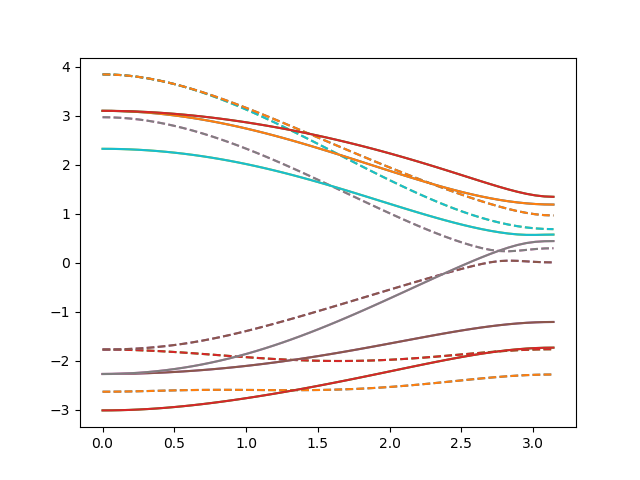

In [70]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

pevs = [la.eigvalsh(proj_h(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**params_ext_fit, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
# for band in np.array(evs).T:
#     plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

### Extended model with pi hoppings and further neighbor constant hoppings

In [71]:
def SnTe_6band_ext2(translations=None):
    """Make bulk 6-band model of SnTe from https://arxiv.org/pdf/1202.1003.pdf

    translations: kwant.lattice.TranslationalSymmetry
        Optional different translational unit cell. Should still be a primitive UC.
    """

    L = L_matrices()
    ### TODO: there may be a 1/2 missing from the spin here
    L_dot_S = np.sum([np.kron(sigmas[i], L[i]) for i in range(3)], axis=0)

    def onsite(site, m, lam):
        # which sublattice
        a = np.sum(site.tag) % 2
        os = m[a] * np.eye(6)
        # L dot S onsite SoC
        spinorb = lam[a] * L_dot_S
        # x, y, z = site.pos
        os = os + spinorb
        return os

    def hopping(site1, site2, ts, tp):
        # which sublattice
        a = np.sum(site1.tag) % 2
        b = np.sum(site2.tag) % 2
        d = site1.tag - site2.tag
        # ppsigma bonding
        Hpps = np.kron(np.eye(2), lcao_term(1, 1, 0, d))
        # Use the appropriate hopping depending on sublattices
        Hppp = np.kron(np.eye(2), lcao_term(1, 1, 1, d))
        # Use the appropriate hopping depending on sublattices
        hop = tp[a, b] * Hppp + ts[a, b] * Hpps
        return hop

    def hopping3(site1, site2, t3):
        hop = t3 * np.eye(6)
        return hop

    def hopping4(site1, site2, t4):
        hop = t4 * np.eye(6)
        return hop

    # Cubic rocksalt structure with FCC symmetry
    lat = kwant.lattice.general(np.eye(3), norbs=6)
    if translations is None:
        # Default translation vectors of FCC structure
        translations = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, 0, 1], [0, 1, 1])
    syst = kwant.Builder(symmetry=translations)

    # Populate the builder using the cubic lattice sites
    # Two sublattices
    syst[lat(0, 0, 0)] = onsite
    syst[lat(0, 0, 1)] = onsite

    # First and second neighbor hoppings
    syst[lat.neighbors(1)] = hopping
    syst[lat.neighbors(2)] = hopping
    syst[lat.neighbors(3)] = hopping3
    syst[lat.neighbors(4)] = hopping4

    return syst


In [72]:
%%time
XTe_18band_params = SnTe_18band_params
syst2 = kwant.wraparound.wraparound(SnTe_6band_ext2()).finalized()
ts_fit = np.zeros((2, 2), dtype=complex)
tp_fit = np.zeros((2, 2), dtype=complex)
m_fit = np.zeros((2,), dtype=complex)
lam_fit = np.zeros((2,), dtype=complex)

for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': t_bas, 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    ts_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': t_bas, 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    tp_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for m_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': m_bas, 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    m_fit += m_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for lam_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': lam_bas, 't3': 0, 't4': 0}
    lam_fit += lam_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 1, 't4': 0}
t3_fit = overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 1}
t4_fit = overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)

SnTe_eff = {'ts': ts_fit, 'tp': tp_fit, 'm': m_fit, 'lam': lam_fit, 't3': t3_fit, 't4': t4_fit}
print(SnTe_eff)

{'ts': array([[-0.2149+0.j,  2.0803+0.j],
       [ 2.0803+0.j, -0.0183+0.j]]), 'tp': array([[ 0.1135+0.j, -0.4095-0.j],
       [-0.4095+0.j,  0.0182+0.j]]), 'm': array([-0.7896-0.j,  0.9907-0.j]), 'lam': array([ 0.2370-0.j,  0.2687-0.j]), 't3': (0.002236864395837884-1.627475622913335e-18j), 't4': (0.090371376254244726-3.5265160791632908e-19j)}
CPU times: user 1min 29s, sys: 21 ms, total: 1min 29s
Wall time: 1min 29s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


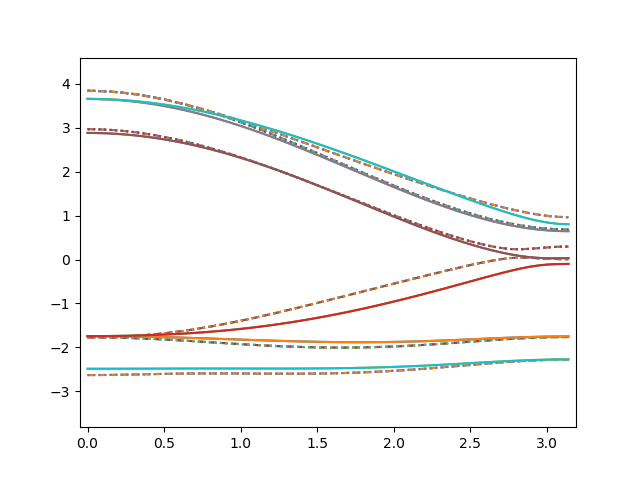

In [73]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

pevs = [la.eigvalsh(proj_h(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**SnTe_eff, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
for band in np.array(evs).T:
    plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

In [74]:
%%time
XTe_18band_params = PbTe_18band_params
syst2 = kwant.wraparound.wraparound(SnTe_6band_ext2()).finalized()
ts_fit = np.zeros((2, 2), dtype=complex)
tp_fit = np.zeros((2, 2), dtype=complex)
m_fit = np.zeros((2,), dtype=complex)
lam_fit = np.zeros((2,), dtype=complex)

for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': t_bas, 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    ts_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for t_bas in np.eye(4).reshape(4, 2, 2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': t_bas, 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    tp_fit += t_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for m_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': m_bas, 'lam': np.zeros((2,)), 't3': 0, 't4': 0}
    m_fit += m_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
for lam_bas in np.eye(2):
    params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': lam_bas, 't3': 0, 't4': 0}
    lam_fit += lam_bas * overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 1, 't4': 0}
t3_fit = overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)
params2 = {'ts': np.zeros((2, 2)), 'tp': np.zeros((2, 2)), 'm': np.zeros((2,)), 'lam': np.zeros((2,)), 't3': 0, 't4': 1}
t4_fit = overlap(proj_h, syst2.hamiltonian_submatrix, grid, XTe_18band_params, params2)

PbTe_eff = {'ts': ts_fit, 'tp': tp_fit, 'm': m_fit, 'lam': lam_fit, 't3': t3_fit, 't4': t4_fit}
print(PbTe_eff)

{'ts': array([[-0.1592+0.j,  1.8893-0.j],
       [ 1.8893+0.j, -0.0174-0.j]]), 'tp': array([[ 0.0866+0.j, -0.3862-0.j],
       [-0.3862+0.j,  0.0340+0.j]]), 'm': array([-0.8413+0.j,  1.9657+0.j]), 'lam': array([ 0.1876+0.j,  0.5814-0.j]), 't3': (0.001674781877227332+6.4175733593037843e-19j), 't4': (0.10725153015748475-3.9838470607068699e-20j)}
CPU times: user 1min 30s, sys: 11.1 ms, total: 1min 30s
Wall time: 1min 29s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


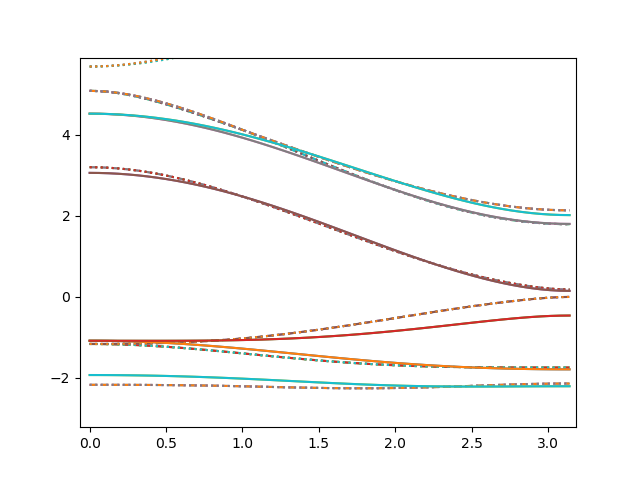

In [75]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

pevs = [la.eigvalsh(proj_h(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**PbTe_eff, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**XTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
for band in np.array(evs).T:
    plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

In [27]:
# SnTe_eff = {'ts': np.array([[-0.2448-0.j,  2.2817+0.j],
#                             [ 2.2817+0.j, -0.0384-0.j]]),
#             'tp': np.array([[ 0.1407+0.j, -0.4589-0.j],
#                             [-0.4589-0.j,  0.0271+0.j]]),
#             'm': np.array([-0.9533-0.j,  1.0881+0.j]),
#             'lam': np.array([ 0.282+0.j,  0.296-0.j]),
#             't3': (-0.0047572899815303557+5.9551371779295825e-19j),
#             't4': (0.098696751805335159+1.0066094644432087e-18j)}

# PbTe_eff = {'ts': np.array([[-0.2004+0.j,  2.1252+0.j],
#                             [ 2.1252+0.j, -0.0573-0.j]]),
#             'tp': np.array([[ 0.1148+0.j, -0.4477+0.j],
#                             [-0.4477+0.j,  0.0382-0.j]]),
#             'm': np.array([-0.9893-0.j,  2.4139+0.j]),
#             'lam': np.array([ 0.214+0.j,  0.750-0.j]),
#             't3': (-0.0025744599754123692+4.0136816585612062e-19j),
#             't4': (0.11670586876167136+2.0531177233834788e-18j)}

# diff = {key: val - PbTe_eff[key] for key, val in SnTe_eff.items()}
# diff

{'ts': array([[-0.0444+0.j,  0.1565+0.j],
        [ 0.1565+0.j,  0.0189+0.j]]), 'tp': array([[ 0.0259+0.j, -0.0112+0.j],
        [-0.0112+0.j, -0.0111+0.j]]), 'm': array([ 0.0360+0.j, -1.3258+0.j]), 'lam': array([ 0.068+0.j, -0.454+0.j]), 't3': (-0.0021828300061179865+1.9414555193683763e-19j), 't4': (-0.018009116956336196-1.04650825894027e-18j)}

# Fit parameters by hand

Find parameters that fit both SnTe and PbTe band structure well with only the onsite terms different (up to overall constant energy shift)

In [28]:
SnTe_eff2 = {'ts': np.array([[-0.2004,  2.1252],
                            [ 2.1252, -0.0573]]),
            'tp': np.array([[ 0.1148, -0.4477],
                            [-0.4477,  0.0382]]),
            'm': 0.3 + np.array([0.8 * -0.9893,  0.75 * 1.0881]),
            'lam': np.array([ 0.22,  0.3]),
            't3': 0,
            't4': 0.08}

PbTe_eff2 = {'ts': np.array([[-0.2004,  2.1252],
                            [ 2.1252, -0.0573]]),
            'tp': np.array([[ 0.1148, -0.4477],
                            [-0.4477,  0.0382]]),
            'm': -0.1 + np.array([0.8 * -0.9893,  0.95 * 2.4139]),
            'lam': np.array([ 0.22,  0.750]),
            't3': 0,
            't4': 0.08}

diff = {key: val - PbTe_eff2[key] for key, val in SnTe_eff2.items()}
diff

{'ts': array([[ 0.,  0.],
        [ 0.,  0.]]), 'tp': array([[ 0.,  0.],
        [ 0.,  0.]]), 'm': array([ 0.4   , -1.0771]), 'lam': array([ 0.  , -0.45]), 't3': 0, 't4': 0.0}

In [4]:
SnTe_eff2 = {'ts': np.array([[-0.2004,  2.1252],
                            [ 2.1252, -0.0573]]),
            'tp': np.array([[ 0.1148, -0.4477],
                            [-0.4477,  0.0382]]),
            'm': 0.3 + np.array([0.8 * -0.9893,  0.75 * 1.0881]),
            'lam': np.array([ 0.22,  0.3]),
            't3': 0,
            't4': 0.08}
print(SnTe_eff2)

{'ts': array([[-0.2 ,  2.13],
       [ 2.13, -0.06]]), 'tp': array([[ 0.11, -0.45],
       [-0.45,  0.04]]), 'm': array([-0.49,  1.12]), 'lam': array([0.22, 0.3 ]), 't3': 0, 't4': 0.08}


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


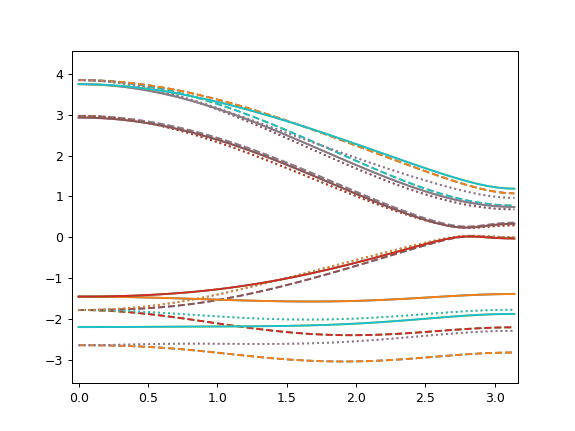

In [29]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

syst2 = kwant.wraparound.wraparound(SnTe_6band_ext2()).finalized()

pevs = [la.eigvalsh(proj_h(params={**SnTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**SnTe_eff2, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**SnTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
for band in np.array(evs).T:
    plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


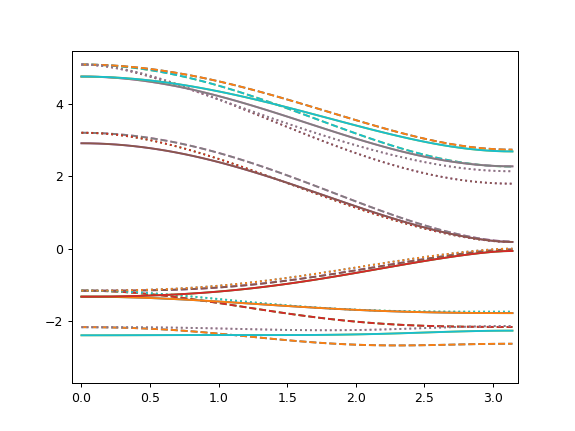

In [30]:
ks = ndlinspace([0, 0, 0], [np.pi, 0, 0], 51)
aks = la.norm(ks, axis=1)

syst2 = kwant.wraparound.wraparound(SnTe_6band_ext2()).finalized()

pevs = [la.eigvalsh(proj_h(params={**PbTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                    params={**PbTe_eff2, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**PbTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

%matplotlib
for band in np.array(pevs).T:
    plt.plot(aks, band, '--')
for band in np.array(evs).T:
    plt.plot(aks, band, ':')
for band in np.array(effevs).T:
    plt.plot(aks, band, '-')

## Virtual crystal approximation alloy band structures

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


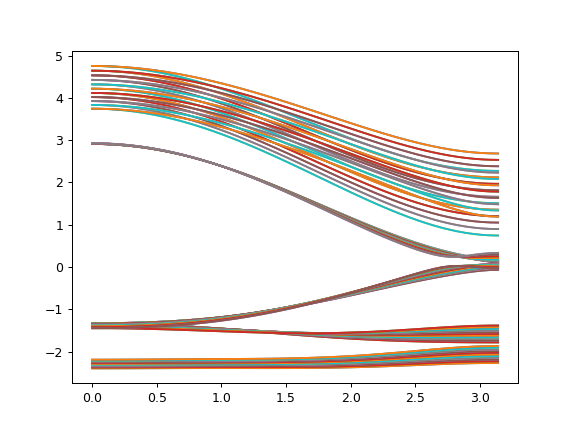

In [31]:
ks = ndlinspace([0, 0, 0], [0, 0, np.pi], 51)
aks = la.norm(ks, axis=1)

%matplotlib
for x in np.linspace(0, 1, 11):
    alloy_params= {key: x * val + (1-x) * PbTe_eff2[key] for key, val in SnTe_eff2.items()}
    syst2 = kwant.wraparound.wraparound(SnTe_6band_ext2()).finalized()

    effevs = [la.eigvalsh(syst2.hamiltonian_submatrix(
                        params={**alloy_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

    plt.plot(aks, np.array(effevs), '-')

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


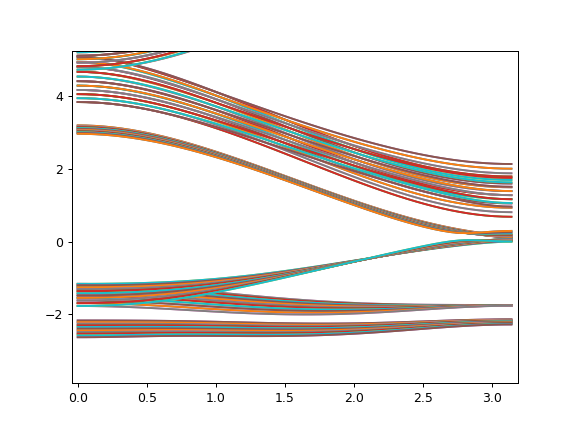

In [32]:
ks = ndlinspace([0, 0, 0], [0, 0, np.pi], 51)
aks = la.norm(ks, axis=1)

%matplotlib
for x in np.linspace(0, 1, 11):
    alloy_params= {key: x * val + (1-x) * PbTe_18band_params[key] for key, val in SnTe_18band_params.items()}
    
    evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**alloy_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

    plt.plot(aks, np.array(evs), '-')

## Compare surface spectra

In [77]:
syst1 = SnTe_6band_ext2()
syst2 = SnTe_18band()

def shape(site):
    return -W//2 <= np.dot(site.tag, n) <= W//2

### [111] surface

In [36]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 160

# Build film using syst
film1 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film1.fill(syst1, shape, start=np.zeros(3));
filmw1 = kwant.wraparound.wraparound(film1)   
filmw1 = filmw1.finalized()

len(filmw1.sites)

161

In [39]:
%%time
pars = SnTe_eff2.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs1 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw1.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs1.append(spec)

CPU times: user 1min 3s, sys: 4.51 s, total: 1min 8s
Wall time: 1min 8s


In [45]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 80

# Build film using syst
film2 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film2.fill(syst2, shape, start=np.zeros(3));
filmw2 = kwant.wraparound.wraparound(film2)
filmw2 = filmw2.finalized()

len(filmw2.sites)

81

In [46]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs2 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw2.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs2.append(spec)

CPU times: user 2min 16s, sys: 9.81 s, total: 2min 26s
Wall time: 2min 26s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


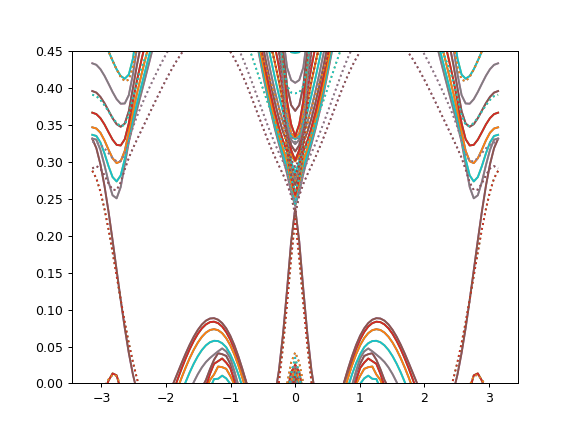

(-0.0, 0.45)

In [47]:
%matplotlib
plt.plot(k_s, specs1)
plt.plot(k_s, specs2, ':')
plt.ylim(-0., 0.45)

other termination

In [58]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 162

# Build film using syst
film1 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film1.fill(syst1, shape, start=np.zeros(3));
filmw1 = kwant.wraparound.wraparound(film1)   
filmw1 = filmw1.finalized()

len(filmw1.sites)

163

In [59]:
%%time
pars = SnTe_eff2.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs1 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw1.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs1.append(spec)

CPU times: user 1min 2s, sys: 3.58 s, total: 1min 5s
Wall time: 1min 5s


In [60]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 82

# Build film using syst
film2 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film2.fill(syst2, shape, start=np.zeros(3));
filmw2 = kwant.wraparound.wraparound(film2)
filmw2 = filmw2.finalized()

len(filmw2.sites)

83

In [61]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs2 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw2.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs2.append(spec)

CPU times: user 2min 19s, sys: 7.62 s, total: 2min 26s
Wall time: 2min 26s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


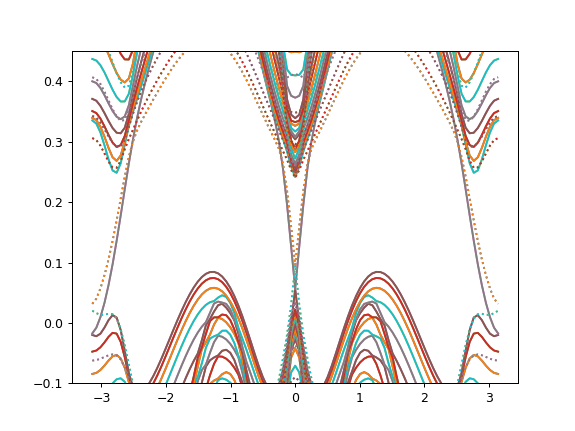

(-0.1, 0.45)

In [63]:
%matplotlib
plt.plot(k_s, specs1)
plt.plot(k_s, specs2, ':')
plt.ylim(-0.1, 0.45)

### [001] surface

In [64]:
# surface normal
n = np.array([0, 0, 1])
# thickness (number of atomic layers - 1)
W = 80

# Build film using syst
film1 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, -1, 0]))

def shape(site):
    return -W//2 <= np.dot(site.tag, n) <= W//2

film1.fill(syst1, shape, start=np.zeros(3));
filmw1 = kwant.wraparound.wraparound(film1)   
filmw1 = filmw1.finalized()

len(filmw1.sites)

162

In [65]:
%%time
pars = SnTe_eff2.copy()
pars['k_x'] = 0
k_s = np.linspace(0, np.pi, 101)
specs1 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw1.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs1.append(spec)

CPU times: user 1min 2s, sys: 172 ms, total: 1min 2s
Wall time: 1min 2s


In [67]:
# surface normal
n = np.array([0, 0, 1])
# thickness (number of atomic layers - 1)
W = 40

# Build film using syst
film2 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, -1, 0]))

film2.fill(syst2, shape, start=np.zeros(3));
filmw2 = kwant.wraparound.wraparound(film2)
filmw2 = filmw2.finalized()

len(filmw2.sites)

82

In [68]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
k_s = np.linspace(0, np.pi, 101)
specs2 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw2.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs2.append(spec)

CPU times: user 2min 20s, sys: 14.5 s, total: 2min 35s
Wall time: 2min 34s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


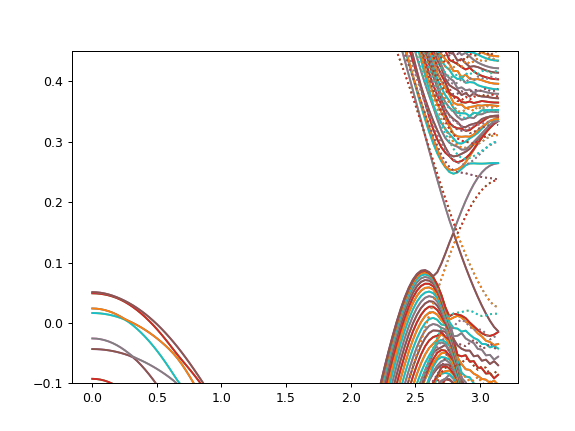

(-0.1, 0.45)

In [69]:
%matplotlib
plt.plot(k_s, specs1)
plt.plot(k_s, specs2, ':')
plt.ylim(-0.1, 0.45)

### [110] surface

In [70]:
# surface normal
n = np.array([1, 1, 0])
# thickness (number of atomic layers - 1)
W = 80

# Build film using syst
film1 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 0, 2]))

def shape(site):
    return -W//2 <= np.dot(site.tag, n) <= W//2

film1.fill(syst1, shape, start=np.zeros(3));
filmw1 = kwant.wraparound.wraparound(film1)   
filmw1 = filmw1.finalized()

len(filmw1.sites)

162

In [71]:
%%time
pars = SnTe_eff2.copy()
pars['k_x'] = 0
k_s = np.linspace(0, np.pi, 101)
specs1 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw1.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs1.append(spec)

CPU times: user 1min 3s, sys: 7.49 s, total: 1min 10s
Wall time: 1min 10s


In [72]:
# surface normal
n = np.array([1, 1, 0])
# thickness (number of atomic layers - 1)
W = 40

# Build film using syst
film2 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 0, 2]))

film2.fill(syst2, shape, start=np.zeros(3));
filmw2 = kwant.wraparound.wraparound(film2)
filmw2 = filmw2.finalized()

len(filmw2.sites)

82

In [73]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
k_s = np.linspace(0, np.pi, 101)
specs2 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw2.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs2.append(spec)

CPU times: user 2min 19s, sys: 20 s, total: 2min 39s
Wall time: 2min 39s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


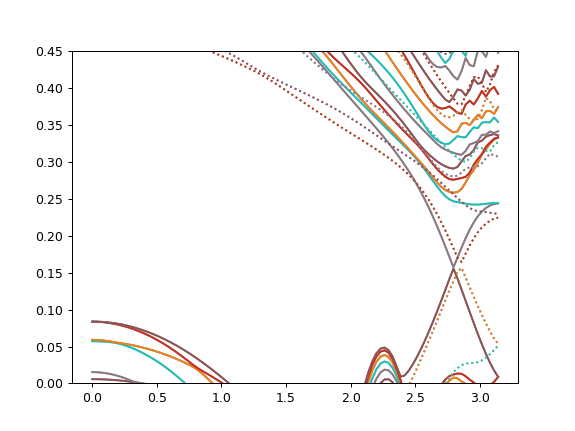

(-0.0, 0.45)

In [74]:
%matplotlib
plt.plot(k_s, specs1)
plt.plot(k_s, specs2, ':')
plt.ylim(-0., 0.45)

# Different projection method for effective Hamiltonian

In [60]:
def proj_h2(params):
    H = bulk.hamiltonian_submatrix(params=params)
    evals, evecs = la.eigh(H)
    # pick out the interesting bands
    overlaps = evecs.T.conj() @ (P @ P.T) @ evecs
    indices = np.argsort(np.diag(overlaps))[-12:]
    evecs = evecs[:, indices]
    # print(evecs.shape)
    phi0 = (evecs @ evecs.T.conj()) @ P
    # print(phi0.shape)
    S = la.inv(la.sqrtm(phi0.T.conj() @ phi0))
    phi1 = phi0 @ S
    # assert np.allclose(phi1.T.conj() @ phi1, np.eye(12))
    return phi1.T.conj() @ H @ phi1

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


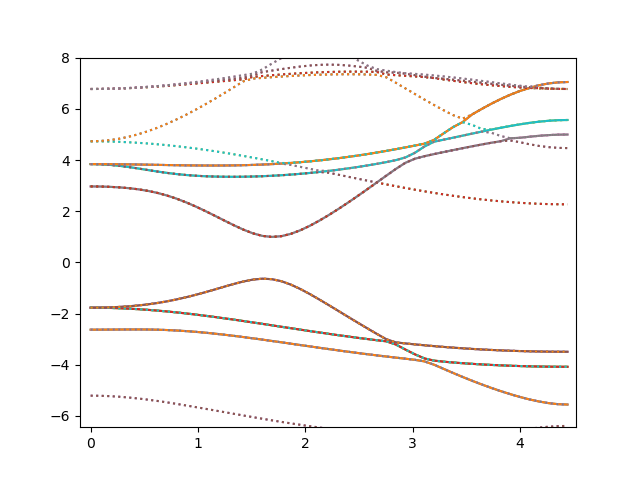

In [76]:
ks = ndlinspace([0, 0, 0], [np.pi, np.pi, 0], 51)
aks = la.norm(ks, axis=1)

evs = [la.eigvalsh(bulk.hamiltonian_submatrix(params={**SnTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]
pevs = [la.eigvalsh(proj_h2(params={**SnTe_18band_params, 'k_x': k[0], 'k_y': k[1], 'k_z': k[2]})) for k in ks]

%matplotlib

for band in np.array(pevs).T:
    plt.plot(aks, band, '-')
for band in np.array(evs).T:
    plt.plot(aks, band, ':')

In [78]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 160

# Build film using syst
film1 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film1.fill(syst1, shape, start=np.zeros(3));
filmw1 = kwant.wraparound.wraparound(film1)   
filmw1 = filmw1.finalized()

len(filmw1.sites)

161

In [79]:
%%time
pars = SnTe_eff.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs1 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw1.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs1.append(spec)

CPU times: user 1min 4s, sys: 5.63 s, total: 1min 9s
Wall time: 1min 10s


In [80]:
# surface normal
n = np.array([1, 1, 1])
# thickness (number of atomic layers - 1)
W = 80

# Build film using syst
film2 = kwant.Builder(kwant.lattice.TranslationalSymmetry([1, -1, 0], [0, 1, -1]))

film2.fill(syst2, shape, start=np.zeros(3));
filmw2 = kwant.wraparound.wraparound(film2)
filmw2 = filmw2.finalized()

len(filmw2.sites)

81

In [81]:
%%time
pars = SnTe_18band_params.copy()
pars['k_x'] = 0
k_s = np.linspace(-np.pi, np.pi, 101)
specs2 = []
for k_y in k_s:
    pars['k_y'] = k_y
    spec = la.eigh(filmw2.hamiltonian_submatrix(params=pars), eigvals_only=True)
    specs2.append(spec)

CPU times: user 2min 6s, sys: 10 s, total: 2min 16s
Wall time: 2min 16s


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


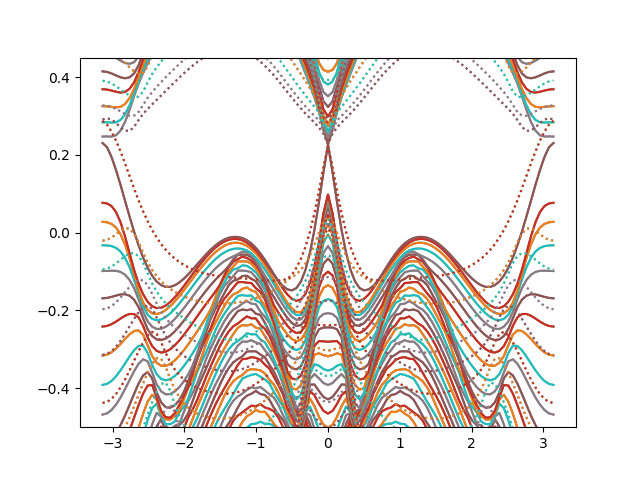

(-0.5, 0.45)

In [85]:
%matplotlib
plt.plot(k_s, np.array(specs1) + 0.2)
plt.plot(k_s, specs2, ':')
plt.ylim(-0.5, 0.45)

In [1]:
import kwant

/home/tinkerer/.conda/envs/stable/lib/python3.6/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)
